In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from control_functional_implementation import *

In [2]:
@jax.jit
def rbf(x, y, length_scale=1.0):
    """Compute the RBF kernel between two points."""
    diff = x - y
    sqdist = jnp.dot(diff, diff)
    return jnp.exp(-0.5 / length_scale**2 * sqdist)

@jax.jit
def stein_rbf(x, y, length_scale=1.0):
    """Compute the Stein kernel between two points using the RBF kernel."""
    diff = x - y
    sqdist = jnp.dot(diff, diff)
    rbf_value = jnp.exp(-0.5 / length_scale**2 * sqdist)
    product = jnp.dot(x, y)
    stein_rbf_value = rbf_value * (1/length_scale**2 - sqdist * (1/length_scale**4 + 1/length_scale**2) + product)
    return stein_rbf_value

def f_in_RKHS(kernel_fn, loc, scale, length_scale=1.0):
    def f(x):
        K = kernel_fn(x, loc, length_scale=length_scale)
        return K @ scale
    return f

In [3]:
# Representative 1
loc1 = jnp.array([-4.0, 1.2, 2.0]).reshape(3, 1)
scale1 = jnp.array([.5, -1.25, 0.75]).reshape(3, 1)

f1_rbf = f_in_RKHS(rbf_kernel, loc1, scale1, length_scale=1.0)
f1_stein = f_in_RKHS(rbf_stein_kernel, loc1, scale1, length_scale=1.0)

# Representative 2
loc2 = jnp.array([-1.2, 2.0]).reshape(2, 1)
scale2 = jnp.array([-1.25, 0.75]).reshape(2, 1)

f2_rbf = f_in_RKHS(rbf_kernel, loc2, scale2, length_scale=1.0)
f2_stein = f_in_RKHS(rbf_stein_kernel, loc2, scale2, length_scale=1.0)

# Representative 3
loc3 = jnp.array([0.4]).reshape(1, 1)
scale3 = jnp.array([0.5]).reshape(1, 1)

f3_rbf = f_in_RKHS(rbf_kernel, loc3, scale3, length_scale=1.0)
f3_stein = f_in_RKHS(rbf_stein_kernel, loc3, scale3, length_scale=1.0)

# plot the functions
x = jnp.linspace(-5, 5, 100).reshape(-1, 1)


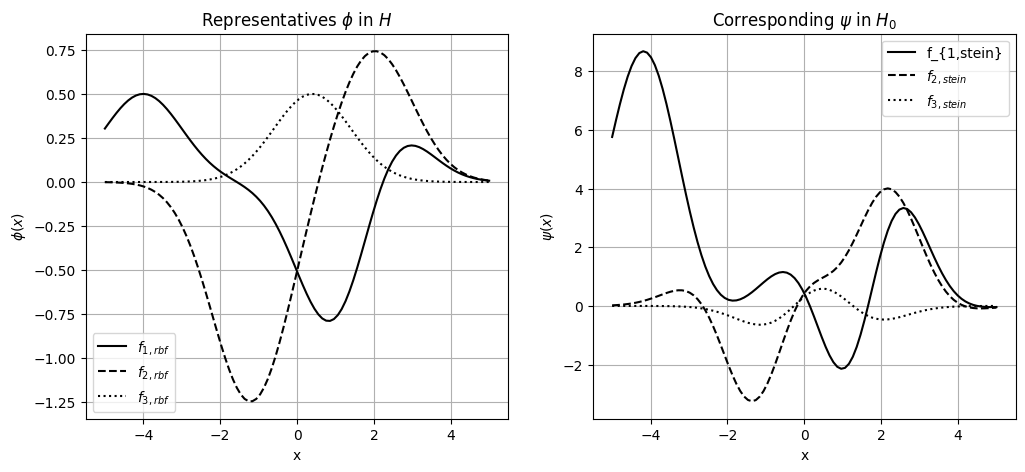

In [4]:
# left plot is f_rbf, right plot is f_stein
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x, f1_rbf(x), label="$f_{1,rbf}$", color="black")
plt.plot(x, f2_rbf(x), label="$f_{2,rbf}$", color="black", linestyle="--")
plt.plot(x, f3_rbf(x), label="$f_{3,rbf}$", color="black", linestyle=":")

plt.xlabel("x")
plt.ylabel("$\\phi(x)$")

plt.title("Representatives $\\phi$ in $H$")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, f1_stein(x), label="f_{1,stein}", color="black")
plt.plot(x, f2_stein(x), label="$f_{2,stein}$", color="black", linestyle="--")
plt.plot(x, f3_stein(x), label="$f_{3,stein}$", color="black", linestyle=":")

plt.xlabel("x")
plt.ylabel("$\\psi(x)$")

plt.title("Corresponding $\\psi$ in $H_{0}$")
plt.grid()
plt.legend()

plt.show()


In [5]:
# Visualize a function being approximated by control functionals using animations
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

# --- Define the target function ---
def f_true(x):
    return jnp.sin(x) + 0.5 * jnp.cos(2 * x)

# --- Data and setup ---
x = jnp.linspace(-5, 5, 200).reshape(-1, 1)
y_true = f_true(x)
y = y_true + 0.1 * jax.random.normal(jax.random.PRNGKey(0), x.shape)

centers = jnp.linspace(-5, 5, 20).reshape(-1, 1)
centers_rev = jnp.flip(centers, axis=0)

# --- Fit coefficients via least squares ---
phi = rbf_kernel(x, centers)
psi = rbf_stein_kernel(x, centers_rev)
alpha, *_ = jnp.linalg.lstsq(phi, y, rcond=None)
beta, *_ = jnp.linalg.lstsq(psi, y, rcond=None)

# --- Animation setup ---
fig, ax = plt.subplots(figsize=(8, 5))
data = ax.scatter(x, y, color='black', label="Noisy data", alpha=0.6)
line_true, = ax.plot(x, y_true, 'tab:red', lw=1, label="True f(x)")
line_fit_phi, = ax.plot([], [], 'tab:orange', lw=1, label="RBF Regression", linestyle='--')
line_fit_psi, = ax.plot([], [], 'tab:orange', lw=2, label="RBF-Stein Regression")

ax.set_title("Fitting with RBF and RBF-stein basis Functions")
ax.legend(loc='lower left')
ax.grid(True)

# Precompute partial fits
f_partial_phi = [phi[:, :i] @ alpha[:i] for i in range(1, len(centers)+1)]
f_partial_psi = [psi[:, :i] @ beta[:i] for i in range(1, len(centers)+1)]

def init():
    line_fit_phi.set_data([], [])
    line_fit_psi.set_data([], [])
    return line_fit_phi, line_fit_psi

def update(frame):
    if frame < len(centers):
        y_fit_phi = f_partial_phi[frame]
        line_fit_phi.set_data(x.squeeze(), y_fit_phi)
    else:
        y_fit_psi = f_partial_psi[frame - len(centers)]
        line_fit_psi.set_data(x.squeeze(), y_fit_psi)
    return line_fit_phi, line_fit_psi

anim = FuncAnimation(fig, update, frames=len(f_partial_phi) * 2,
                    init_func=init, blit=True, interval=100, repeat=True)

# Prevent extra static figure
plt.close(fig)

# Display in Jupyter
HTML(anim.to_jshtml())

In [6]:
# --- Verify mean zero property of Stein functions ---
n = 100_000
key = jax.random.PRNGKey(0)
Z = jax.random.normal(key, (n, 1))

# --- RBF functions ---
X1 = f1_rbf(Z)
X2 = f2_rbf(Z)
X3 = f3_rbf(Z)

# --- Stein functions ---
Y1 = f1_stein(Z)
Y2 = f2_stein(Z)
Y3 = f3_stein(Z)

# --- Print means ---
print("Means of phi(Z)")
print(f"{X1.mean():.4f}\t{X2.mean():.4f}\t{X3.mean():.4f}")
print("-----------------------")
print("Means of psi(Z)")
print(f"{Y1.mean():.4f}\t{Y2.mean():.4f}\t{Y3.mean():.4f}")


Means of phi(Z)
-0.4145	-0.4221	0.3393
-----------------------
Means of psi(Z)
-0.0003	-0.0020	-0.0004


In [7]:
# --- Butterfly Multi-strike Option ---
def black_scholes_call(S_0, K, r, T, sigma):
    """Black-Scholes formula for European call option price."""
    from jax.scipy.stats import norm

    d1 = (jnp.log(S_0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * jnp.sqrt(T))
    d2 = d1 - sigma * jnp.sqrt(T)

    call_price = S_0 * norm.cdf(d1) - K * jnp.exp(-r * T) * norm.cdf(d2)
    return call_price

def black_scholes_butterfly(S_0, K1, K2, K3, r, T, sigma):
    """Black-Scholes formula for a butterfly multi-strike option price."""
    C1 = black_scholes_call(S_0, K1, r, T, sigma)
    C2 = black_scholes_call(S_0, K2, r, T, sigma)
    C3 = black_scholes_call(S_0, K3, r, T, sigma)
    
    return C1 - 2 * C2 + C3

def butterfly_option_payoff(S, K1, K2, K3):
    """Compute the payoff of a butterfly spread option."""
    payoff = jnp.maximum(S - K1, 0) - 2 * jnp.maximum(S - K2, 0) + jnp.maximum(S - K3, 0)
    return payoff

def plain_monte_carlo(S_0, K1, K2, K3, r, T, sigma, n, key):
    """Estimate the price of a butterfly option using plain Monte Carlo."""
    # Simulate end-of-period stock prices
    Z = jax.random.normal(key, (n,))
    S_T = S_0 * jnp.exp((r - 0.5 * sigma**2) * T + sigma * jnp.sqrt(T) * Z)
    
    # Compute payoffs
    payoffs = butterfly_option_payoff(S_T, K1, K2, K3)

    # Discounted payoffs
    discounted_payoffs = jnp.exp(-r * T) * payoffs
    
    # Discounted expected payoff
    est = jnp.mean(discounted_payoffs)
    std_err = jnp.std(discounted_payoffs, ddof=1) / jnp.sqrt(n)
    rel_err = std_err / jnp.abs(est)

    return est, std_err, rel_err, Z, discounted_payoffs

def control_variate_final_price(S_0, K1, K2, K3, r, T, sigma, n, key):
    """Estimate the price of a butterfly option using control variates with final stock price."""
    # Simulate end-of-period stock prices
    Z = jax.random.normal(key, (n,))
    S_T = S_0 * jnp.exp((r - 0.5 * sigma**2) * T + sigma * jnp.sqrt(T) * Z)
    
    # Compute payoffs
    payoffs = butterfly_option_payoff(S_T, K1, K2, K3)
    
    # Control variate: final stock price
    control_variate = S_T
    
    # Compute covariance and variance
    cov = jnp.cov(payoffs, control_variate)[0, 1]
    var_control = jnp.var(control_variate)
    
    # Optimal coefficient
    b_opt = cov / var_control
    
    # Adjusted payoffs
    adjusted_payoffs = payoffs - b_opt * (control_variate - S_0 * jnp.exp(r * T))

    # Discounted adjusted payoff
    discounted_payoffs = jnp.exp(-r * T) * adjusted_payoffs
    
    # Discounted expected adjusted payoff
    est = jnp.mean(discounted_payoffs)
    std_err = jnp.std(discounted_payoffs, ddof=1) / jnp.sqrt(n)
    rel_err = std_err / jnp.abs(est)

    return est, std_err, rel_err, Z, discounted_payoffs

In [8]:
# Setup
key1 = jax.random.PRNGKey(1)
key2 = jax.random.PRNGKey(2)
key3 = jax.random.PRNGKey(3)

n = 10_000
S_0, K1, K2, K3 = 60.0, 90.0, 100.0, 120.0   # Deep Out of the Money
r, T, sigma = 0.05, 1.0, 0.3

theoretical_price = black_scholes_butterfly(S_0, K1, K2, K3, r, T, sigma)
est_plain, se_plain, re_plain, Z_plain, payoffs_plain = plain_monte_carlo(
    S_0, K1, K2, K3, r, T, sigma, n, key1)
est_cv, se_cv, re_cv, Z_cv, payoffs_cv = control_variate_final_price(
    S_0, K1, K2, K3, r, T, sigma, n, key2)

print(f"Theoretical Price: {theoretical_price:.4f}")
print(f"Plain MC Estimate: {est_plain:.4f}, SE: {se_plain:.4f}, RE: {re_plain:.4%}")
print(f"Control Variate Estimate: {est_cv:.4f}, SE: {se_cv:.4f}, RE: {re_cv:.4%}")

Theoretical Price: 0.1628
Plain MC Estimate: 0.1585, SE: 0.0179, RE: 11.2799%
Control Variate Estimate: 0.1608, SE: 0.0181, RE: 11.2674%


In [9]:
# --- Control Functional Estimator ---
Z_cf = Z_plain.reshape(-1, 1)
Y_cf = payoffs_plain.reshape(-1, 1)

cf_model = ControlFunctional(Z_cf, Y_cf, key3, r=0.40, length_scale=0.25)
cf_model.fit(alpha=1e-3)
cf_model.predict()

y_pred = cf_model.pred

x_train, y_train = cf_model.X_train, cf_model.Y_train
x_test, y_test = cf_model.X_test, cf_model.Y_test

cf_model.summary()

Unbiased Est.: 0.162837
Simplified Est.: 0.164406
SE: 0.002263
RE: 1.3895%


In [10]:
# --- Variance Reduction Factor ---
vrf_plain_cv = re_plain**2 / re_cv**2
print(f"VRF (CV): {vrf_plain_cv:.2f}")

vrf_plain_cf = re_plain**2 / cf_model.re_err**2
print(f"VRF (CF): {vrf_plain_cf:.2f}")

VRF (CV): 1.00
VRF (CF): 65.90


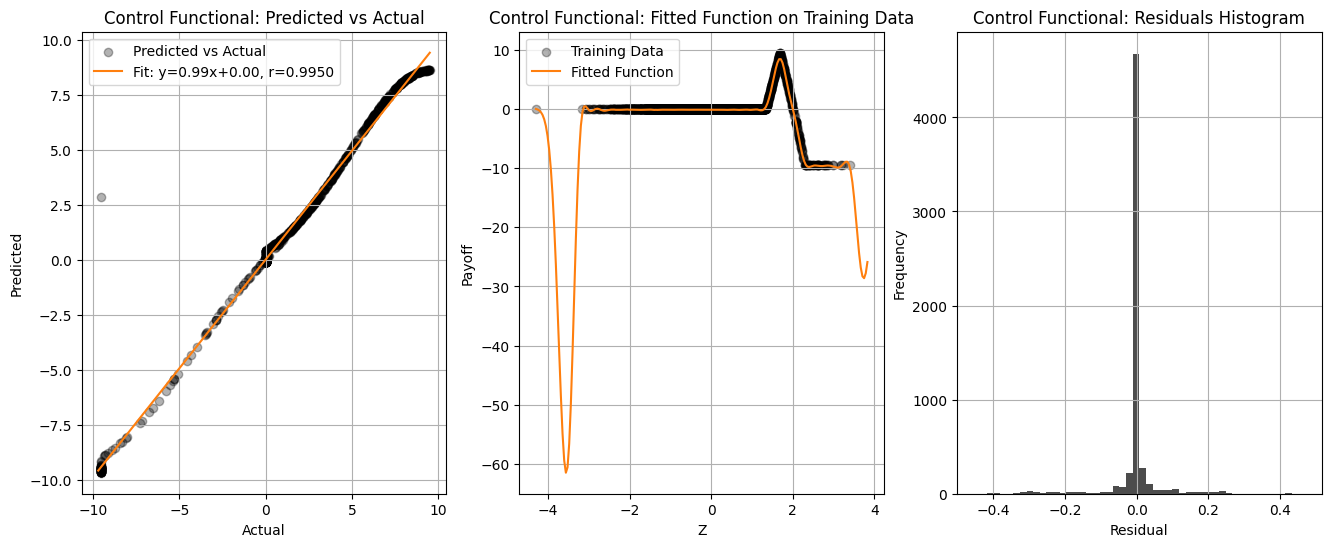

In [11]:
plt.figure(figsize=(16, 6))

# plot y_test vs. y_pred
plt.subplot(1, 3, 1)
plt.scatter(cf_model.Y_test, y_pred, color='black', alpha=0.3, label="Predicted vs Actual")

# plot y_pred ~ y_test line and find the correlation coefficient
min_val = min(jnp.min(cf_model.Y_test), jnp.min(y_pred))
max_val = max(jnp.max(cf_model.Y_test), jnp.max(y_pred))

jnp.polyfit(cf_model.Y_test.flatten(), y_pred.flatten(), 1)
slope, intercept = jnp.polyfit(cf_model.Y_test.flatten(), y_pred.flatten(), 1)
corr = jnp.corrcoef(cf_model.Y_test.flatten(), y_pred.flatten())[0, 1]

plt.plot([min_val, max_val], [slope * min_val + intercept, slope * max_val + intercept], color='tab:orange', label=f"Fit: y={slope:.2f}x+{intercept:.2f}, r={corr:.4f}")

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Control Functional: Predicted vs Actual")

plt.legend()
plt.grid()

# plot x_train vs. y_train + fitted function
plt.subplot(1, 3, 2)

plt.scatter(x_train, y_train, color='black', alpha=0.3, label="Training Data")

xx = jnp.linspace(jnp.min(Z_cf), jnp.max(Z_cf), 200).reshape(-1, 1)
K_xx = rbf_stein_kernel(xx, x_train, length_scale=0.25)
fitted_values = K_xx @ cf_model.coeffs

plt.plot(xx, fitted_values, color='tab:orange', label="Fitted Function")
plt.xlabel("Z")
plt.ylabel("Payoff")
plt.title("Control Functional: Fitted Function on Training Data")

plt.legend()
plt.grid()

# plot residuals histogram
plt.subplot(1, 3, 3)

resid = cf_model.residuals

# remove outliers for better visualization
resid = resid[jnp.abs(resid) < 2.9 * jnp.std(resid)]

plt.hist(resid, bins=50, color='black', alpha=0.7)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Control Functional: Residuals Histogram")

plt.grid()

plt.show()

In [12]:
# # Response Variables: Variance Reduction Factor, Computational Cost
# # Parameters: Choice of training and test split, length scale, regularization parameter.

# import time

# N = 100  # number of runs for averaging

# # --- Varying training set ratio ---
# r_values = jnp.arange(0.05, 0.95, 0.05)
# alpha_values = [1e-1, 1e-2, 1e-3, 1e-4]

# vrf_avg_values = {alpha: [] for alpha in alpha_values}
# time_avg_values = {alpha: [] for alpha in alpha_values}

# for r in r_values:
#     for alpha in alpha_values:
#         # Compute average VRF over multiple runs
#         vrf_values = jnp.zeros(N)
#         time_values = jnp.zeros(N)

#         for i in range(N):
#             key3, subkey = jax.random.split(key3)
#             cf_model = ControlFunctional(Z_cf, Y_cf, subkey, r=r, length_scale=0.25)
            
#             # Time the fitting and prediction
#             start_time = time.time()
#             cf_model.fit(alpha=alpha)
#             cf_model.predict()
#             end_time = time.time()
            
#             time_values = time_values.at[i].set(end_time - start_time)
        
#             vrf = re_plain**2 / cf_model.re_err**2
#             vrf_values = vrf_values.at[i].set(vrf)
            
#         vrf_avg = jnp.mean(vrf_values)
#         vrf_avg_values[alpha].append(vrf_avg)

#         time_avg = jnp.mean(time_values)
#         time_avg_values[alpha].append(time_avg)

# # Plot VRF and Time vs. Training Set Ratio
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# for alpha in alpha_values:
#     plt.plot(r_values, vrf_avg_values[alpha], marker='o', label=f"alpha={alpha}")

# plt.xlabel("Training Set Ratio (r)")
# plt.ylabel("Average VRF")
# plt.title("VRF vs. Training Set Ratio")
# plt.legend()
# plt.grid()

# # Very unreliable time measurements, because it is run with other background processes
# plt.subplot(1, 2, 2)
# for alpha in alpha_values:
#     plt.plot(r_values, time_avg_values[alpha], marker='o', label=f"alpha={alpha}")
# plt.xlabel("Training Set Ratio (r)")
# plt.ylabel("Average Time (s)")
# plt.title("Computation Time vs. Training Set Ratio")
# plt.legend()
# plt.grid()

# plt.show()
